In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import os
import sys
import pandas as pd

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.models import load_model

Using TensorFlow backend.


In [3]:
MODEL_NAME = 'life-threatening_arrhythmias'
PATH_DATASET = '/home/nsc/seers/dataset/' + MODEL_NAME
FILE_DATASET = 'dataset.csv'

print (os.path.join(PATH_DATASET, FILE_DATASET))

/home/nsc/seers/dataset/life-threatening_arrhythmias/dataset.csv


In [62]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):
    
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())

In [5]:
def read_data(path, file):

    """
    This function reads the life-threatening_arrhythmias data from a file
    Args:
        file_path: path to the CSV file
    Returns:
        A pandas dataframe
    """
    
    print(os.path.join(path, file))
    # dataset.csv
    # record	alarm_label	arrhythmia	lead_ii_max	lead_ii_min	lead_ii_file
    df_csv = pd.read_csv(os.path.join(path, file), sep=',')

    return df_csv

In [6]:
def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

In [7]:
def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

    
def plot_arrhythmia(path, arrhythmia, df_t, count=1):
    
    df_t = df_t[df_t['arrhythmia'] == arrhythmia]
    df_true = df_t[df_t['alarm_label'] == True].sample(frac=1).reset_index(drop=True)
    df_false = df_t[df_t['alarm_label'] == False].sample(frac=1).reset_index(drop=True)
    for idx in range(count):
        fig, (ax0, ax1) = plt.subplots(nrows=2,
             figsize=(15, 5),
             sharex=True)
        df_lead_ii = pd.read_csv(os.path.join(path, df_true['lead_ii_file'][idx]), header=None)
        df_lead_ii.columns = ['lead_ii']
        plot_axis(ax0, df_lead_ii.index, df_lead_ii['lead_ii'], df_true['lead_ii_file'][idx])
        df_lead_ii = pd.read_csv(os.path.join(path, df_false['lead_ii_file'][idx]), header=None)
        df_lead_ii.columns = ['lead_ii']
        plot_axis(ax1, df_lead_ii.index, df_lead_ii['lead_ii'], df_false['lead_ii_file'][idx])
        plt.subplots_adjust(hspace=0.2)
        fig.suptitle(arrhythmia)
        plt.subplots_adjust(top=0.90)
        plt.show()

In [8]:
def create_segments_and_labels(path, df_dataset, series_record, label_name):

    # lead-II acceleration as features
    N_FEATURES = 1
    TIME_STEPS = 2500
    
    segments = []
    labels = []
    for idx_item, value in series_record.iteritems():
        df_record = df_dataset[df.record == value]
        for idx_row, row in df_record.iterrows():
            df_lead_ii = pd.read_csv(os.path.join(path, row['lead_ii_file']), header=None)
            df_lead_ii.columns = ['lead_ii']
            
            # Normalize features for data set
            df_lead_ii['lead_ii'] = ((df_lead_ii['lead_ii'] - df['lead_ii_min']) 
                                     / (df['lead_ii_max'] - df['lead_ii_min']))
            
            # Round in order to comply to NSNumber from iOS
            df_lead_ii = df_lead_ii.round({'lead_ii': 6})
                        
            segments.append([df_lead_ii['lead_ii'].values,])
            labels.append(row[label_name])

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_STEPS, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

In [9]:
# %%

# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["False",
          "True"]

# The number of steps within one time segment
TIME_PERIODS = 2500

# %%

keras version  2.2.4


In [10]:
print("\n--- Load, csv data ---\n")

# Load data set containing all the data from csv
df = read_data(PATH_DATASET, FILE_DATASET)


--- Load, csv data ---

/home/nsc/seers/dataset/life-threatening_arrhythmias/dataset.csv


In [11]:
# Describe the data
show_basic_dataframe_info(df, 20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 6462

First 20 rows of the dataframe:

   record  alarm_label arrhythmia  lead_ii_max  lead_ii_min  \
0   a103l        False   Asystole          1.8         -0.8   
1   a104s        False   Asystole          2.0         -0.9   
2   a105l        False   Asystole          2.0         -0.8   
3   a109l        False   Asystole          2.0         -0.9   
4   a134s        False   Asystole          5.1         -5.1   
5   a142s         True   Asystole          0.6         -0.2   
6   a145l        False   Asystole          0.8         -1.3   
7   a161l         True   Asystole          0.3         -1.4   
8   a163l        False   Asystole          4.6         -2.4   
9   a165l        False   Asystole          3.2         -1.9   
10  a167l         True   Asystole          0.5         -0.0   
11  a170s        False   Asystole          0.8         -0.7   
12  a171l        False   Asystole          0.7         -0.5   
13  a172

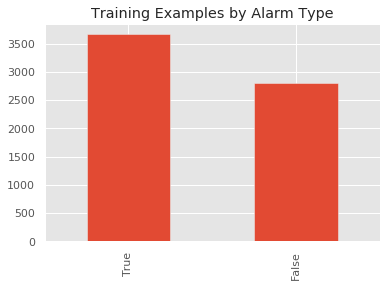

In [12]:
df['alarm_label'].value_counts().plot(kind='bar',
                                   title='Training Examples by Alarm Type')
plt.show()

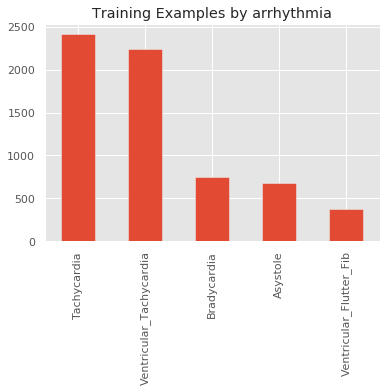

In [13]:
df['arrhythmia'].value_counts().plot(kind='bar',
                                  title='Training Examples by arrhythmia')
plt.show()

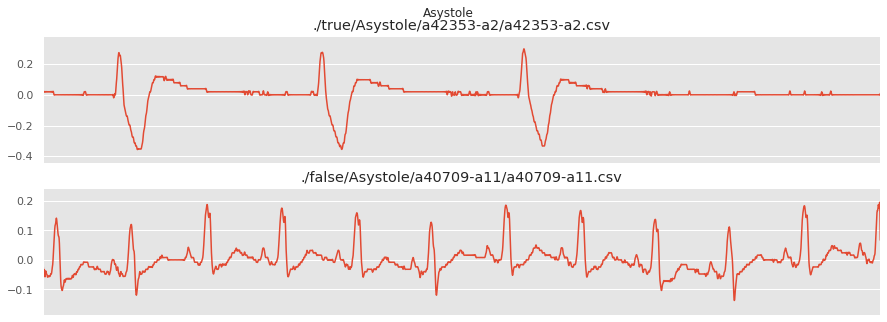

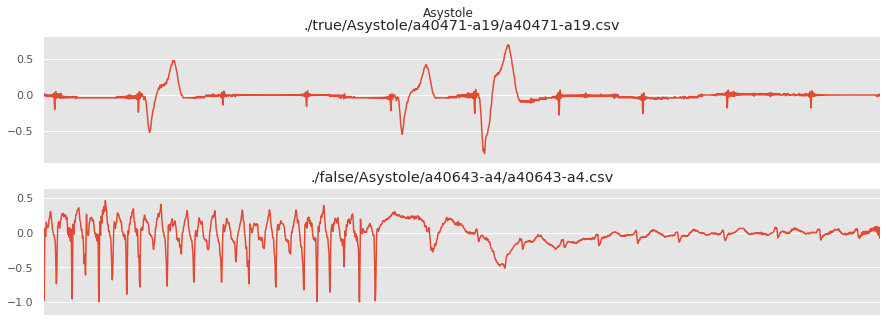

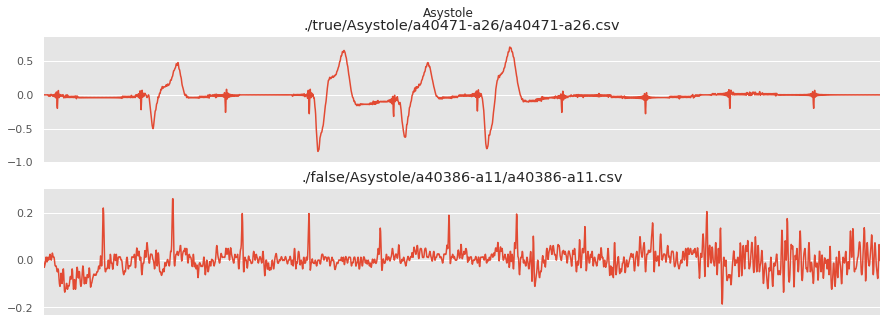

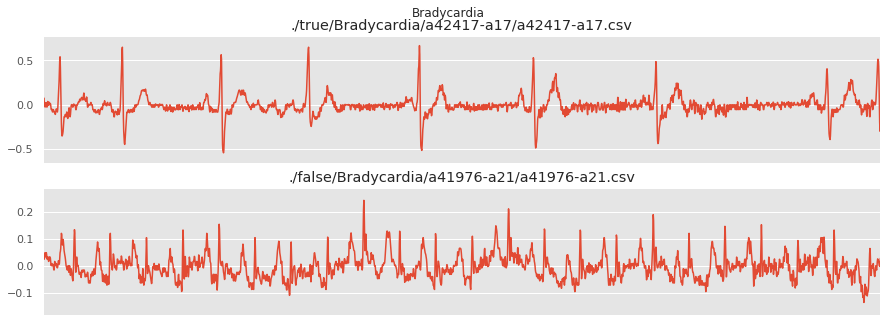

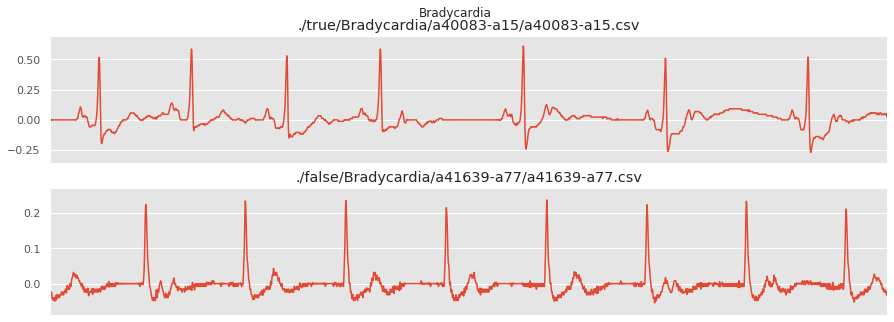

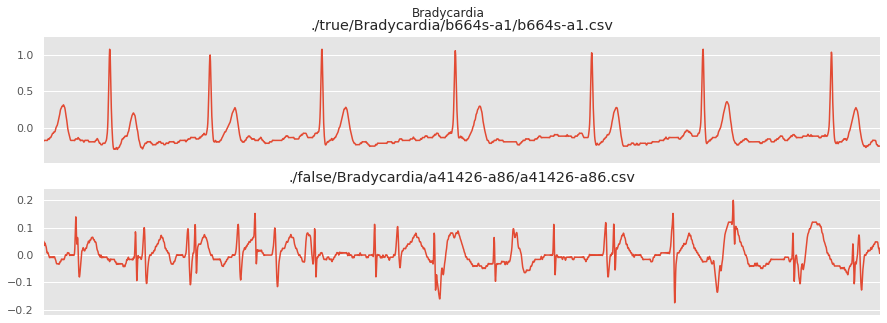

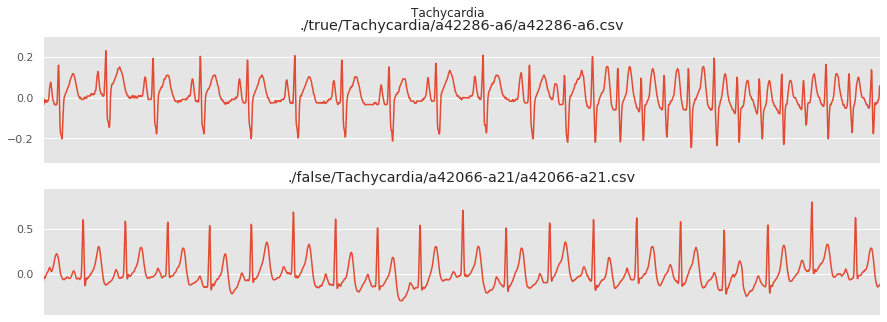

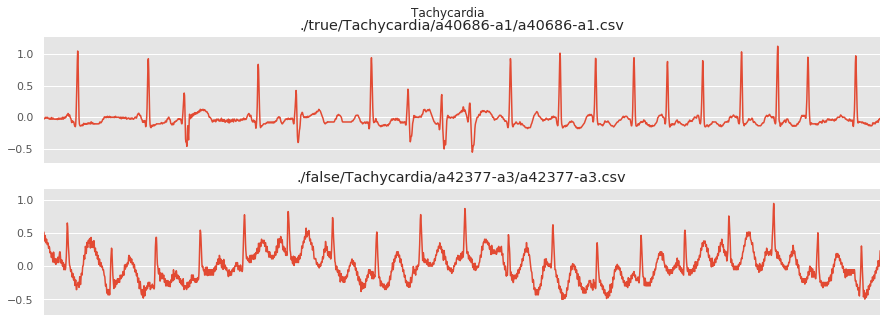

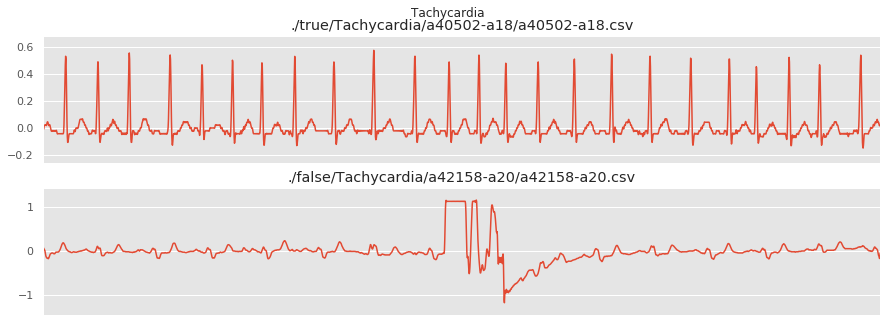

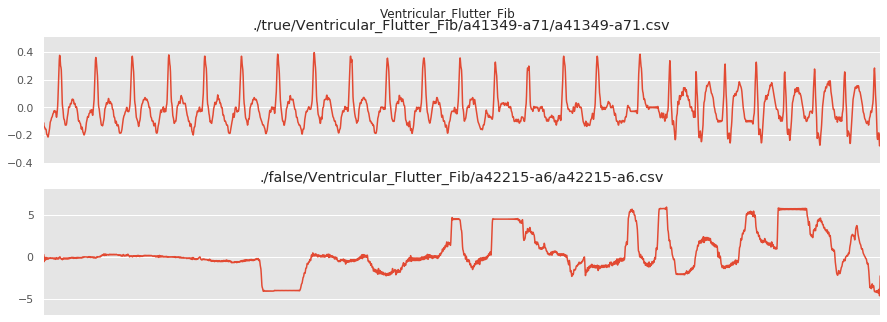

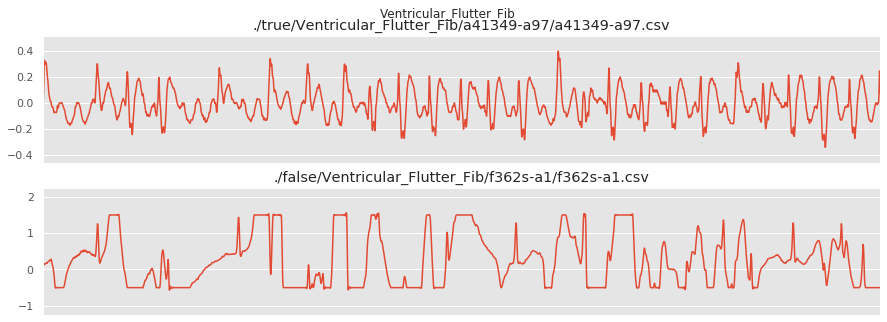

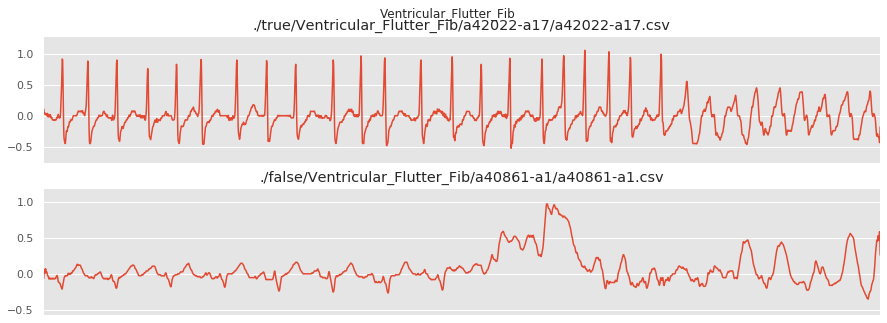

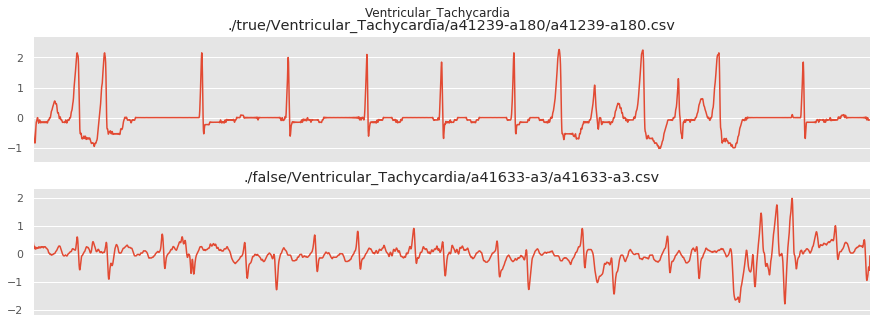

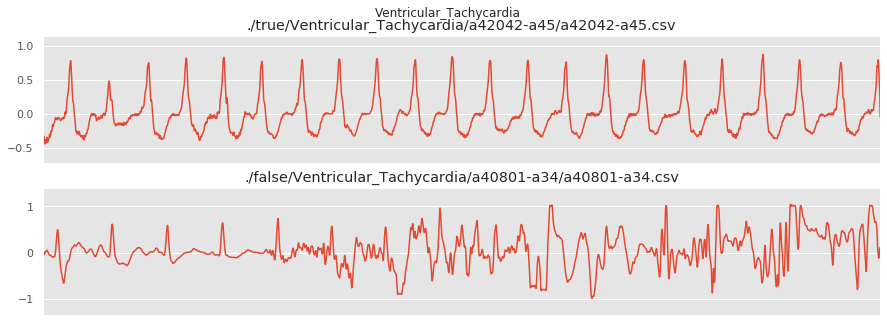

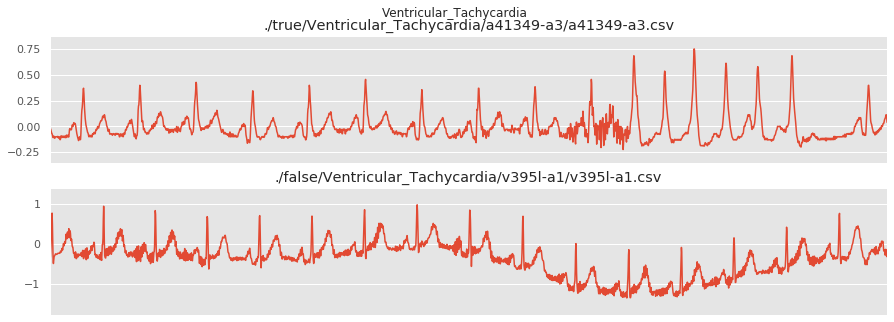

In [14]:
for arrhythmia in np.unique(df["arrhythmia"]):
    plot_arrhythmia(PATH_DATASET,arrhythmia, df, count=3)

In [15]:
# Define column name of the label vector
LABEL = "alarm_encoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["alarm_label"].values.ravel())

In [16]:
df

,record,alarm_label,arrhythmia,lead_ii_max,lead_ii_min,lead_ii_file,alarm_encoded
0,a103l,False,Asystole,1.8,-0.8,./false/Asystole/a103l-a1/a103l-a1.csv,0
1,a104s,False,Asystole,2.0,-0.9,./false/Asystole/a104s-a1/a104s-a1.csv,0
2,a105l,False,Asystole,2.0,-0.8,./false/Asystole/a105l-a1/a105l-a1.csv,0
3,a109l,False,Asystole,2.0,-0.9,./false/Asystole/a109l-a1/a109l-a1.csv,0
4,a134s,False,Asystole,5.1,-5.1,./false/Asystole/a134s-a1/a134s-a1.csv,0
5,a142s,True,Asystole,0.6,-0.2,./true/Asystole/a142s-a1/a142s-a1.csv,1
6,a145l,False,Asystole,0.8,-1.3,./false/Asystole/a145l-a1/a145l-a1.csv,0
7,a161l,True,Asystole,0.3,-1.4,./true/Asystole/a161l-a1/a161l-a1.csv,1
8,a163l,False,Asystole,4.6,-2.4,./false/Asystole/a163l-a1/a163l-a1.csv,0
9,a165l,False,Asystole,3.2,-1.9,./false/Asystole/a165l-a1/a165l-a1.csv,0


In [17]:
# %%

print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
series_record = df['record']
series_record = series_record.drop_duplicates(keep='last')
#df_record = df_record.sample(frac=1).reset_index(drop=True)
series_record_train, series_record_test = train_test_split(series_record, test_size=0.1)
series_record_train = series_record_train.reset_index(drop=True)
series_record_test = series_record_test.reset_index(drop=True)


# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(PATH_DATASET,
                                              df,
                                              series_record_train,
                                              LABEL)

# %%


--- Reshape the data into segments ---



In [18]:
x_train

array([[[0.278862],
        [0.287938],
        [0.264499],
        ...,
        [0.357678],
        [0.618071],
        [0.612315]],

       [[0.29527 ],
        [0.298437],
        [0.271963],
        ...,
        [0.331943],
        [0.595958],
        [0.590119]],

       [[0.300466],
        [0.305196],
        [0.28194 ],
        ...,
        [0.356934],
        [0.616162],
        [0.601738]],

       ...,

       [[0.265985],
        [0.277873],
        [0.232288],
        ...,
        [0.188186],
        [0.461889],
        [0.502776]],

       [[0.283227],
        [0.286056],
        [0.248838],
        ...,
        [0.243447],
        [0.528923],
        [0.554333]],

       [[0.283227],
        [0.272635],
        [0.248838],
        ...,
        [0.475204],
        [0.696506],
        [0.624753]]], dtype=float32)

In [19]:
print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (5030, 2500, 1)
print(x_train.shape[0], 'training samples')
# Displays 5030 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (5030,)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))


--- Reshape data to be accepted by Keras ---

x_train shape:  (5936, 2500, 1)
5936 training samples
y_train shape:  (5936,)
[False, True]


In [20]:
num_time_periods

2500

In [21]:
input_shape = (num_time_periods*num_sensors)

print('x_train shape:', x_train.shape)
# x_train shape: (5018, 2500)
print('input_shape:', input_shape)
# input_shape: (2500)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

x_train shape: (5936, 2500, 1)
input_shape: 2500


In [22]:
y_train

array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [23]:
# %%

# One-hot encoding of y_train labels (only execute once!)
# y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
# (4173, 6)

# %%

New y_train shape:  (5936,)


In [24]:
y_train

array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [25]:
TIME_PERIODS

2500

In [26]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
#model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(1, activation='sigmoid'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

W1016 10:23:06.612279 139900753995584 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1016 10:23:06.629504 139900753995584 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1016 10:23:06.632279 139900753995584 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1016 10:23:06.666501 139900753995584 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is depre


--- Create neural network model ---

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2491, 100)         1100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2482, 100)         100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 827, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 818, 160)          160160    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 809, 160)          256160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16

In [28]:
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=10)
]

model_m.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 250
EPOCHS = 100

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

W1016 10:25:49.468439 139900753995584 deprecation.py:323] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



--- Fit the model ---

Train on 4748 samples, validate on 1188 samples
Epoch 1/100
4748/4748 [==============================] - 34s 7ms/step - loss: 0.6862 - acc: 0.5720 - val_loss: 0.6624 - val_acc: 0.6204
Epoch 2/100
4748/4748 [==============================] - 21s 4ms/step - loss: 0.6752 - acc: 0.5941 - val_loss: 0.6578 - val_acc: 0.6204
Epoch 3/100
4748/4748 [==============================] - 21s 4ms/step - loss: 0.6743 - acc: 0.5950 - val_loss: 0.6603 - val_acc: 0.6237
Epoch 4/100
4748/4748 [==============================] - 21s 4ms/step - loss: 0.6689 - acc: 0.6028 - val_loss: 0.6465 - val_acc: 0.6288
Epoch 5/100
4748/4748 [==============================] - 21s 5ms/step - loss: 0.6586 - acc: 0.6066 - val_loss: 0.6448 - val_acc: 0.6305
Epoch 6/100
4748/4748 [==============================] - 21s 5ms/step - loss: 0.6390 - acc: 0.6247 - val_loss: 0.6310 - val_acc: 0.6473
Epoch 7/100
4748/4748 [==============================] - 21s 4ms/step - loss: 0.6136 - acc: 0.6493 - val_loss: 0


--- Learning curve of model training ---



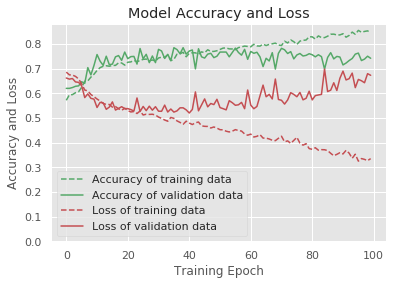

In [29]:
# %%

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

#%%

In [30]:
print("\n--- Check against test data ---\n")

x_test, y_test = create_segments_and_labels(PATH_DATASET,
                                              df,
                                              series_record_test,
                                              LABEL)


--- Check against test data ---



In [31]:
x_test.shape

(526, 2500, 1)

In [33]:
x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

# y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

526/526 [==============================] - 1s 1ms/step

Accuracy on test data: 0.67

Loss on test data: 0.79



--- Confusion matrix for test data ---



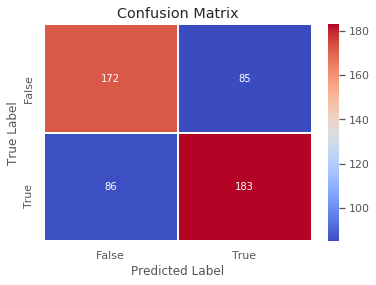


--- Classification report for test data ---

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67       257
         1.0       0.68      0.68      0.68       269

    accuracy                           0.67       526
   macro avg       0.67      0.67      0.67       526
weighted avg       0.67      0.67      0.67       526



In [70]:
# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_pred_test = (y_pred_test+0.5) // 1
max_y_test = y_test

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [138]:
model_m.save(MODEL_NAME+'.h5')

In [139]:
model_l = load_model(MODEL_NAME+'.h5')

In [140]:
score_l = model_l.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score_l[1])
print("\nLoss on test data: %0.2f" % score_l[0])

854/854 [==============================] - 2s 2ms/step

Accuracy on test data: 0.69

Loss on test data: 0.73
